# BL 일간 리밸런싱 백테스트
- 기존 Ridge + Black-Litterman 코드를 재활용
- 일별 리밸런싱 포트폴리오 성과(샤프, MDD)와 시각화


In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(x, **kwargs):
        return x

import warnings
warnings.filterwarnings("ignore")

In [1]:
# =========================
# Config
# =========================
# Paths
EMBEDDING_PATH = "data/kospidaq_embeddings_OpenAI.xlsx"
RETURN_PATH    = "data/report_return_mapping.xlsx"
ADJ_CLOSE_PATH = "data/adj_close_wide_2014_2026.xlsx"
MCAP_PATH      = "data/market_cap_2014_2025.xlsx"
KOSPI_PATH     = "data/kospi_krx_20130102_20251230.xlsx"
RISK_FREE_PATH = "data/treasury3m_proxy_krx_20130102_20251230.xlsx"

# Core dates
DATA_START_DATE = "2014-01-02"

# Core return settings
# Raw report return in mapping file (usually log_return_1)
RAW_TARGET_RETURN_COL = "log_return_1"
# Model/BL target in this notebook
TARGET_RETURN_COL = "log_return_1"
RETURN_COLS = [RAW_TARGET_RETURN_COL]
BACKTEST_RETURN_COL = "simple_return_1"

# Unified rolling window
WINDOW = 504

# Ridge settings
RIDGE_ALPHA = 10.0
MIN_TRAIN_SAMPLES = 0

# Preprocess settings
MIN_REPORT_COUNT = 10
WINSOR_LOWER_Q = 0.01
WINSOR_UPPER_Q = 0.99

# Risk settings
RISK_AVERSION = 2.5
RISK_FREE_TRADING_DAYS = 252
OMEGA_MIN_OBS = 20
OMEGA_FALLBACK_MSE = 1e-4
OMEGA_WARMUP_DAYS = WINDOW

# BL / portfolio settings
MIN_COVERAGE = 1.0
TAU = 0.05  # None -> 1 / n
LONG_ONLY = True
WEIGHT_CLIP = None  # e.g. 0.05

# Backtest settings
TRANSACTION_COST_BPS = 0.0      # buy/sell commission (bps)
SELL_TAX_BPS = 0.0              # sell-side tax (bps)

ANNUALIZATION = 252

## 데이터 로드


In [3]:
df_embed = pd.read_excel(EMBEDDING_PATH)
df_ret = pd.read_excel(RETURN_PATH)

print(df_embed.shape)
print(df_ret.shape)

(62450, 1538)
(62450, 14)


## 컬럼 선택 및 집계


In [4]:
from IPython.display import display

embedding_cols = [c for c in df_embed.columns if c.startswith("embedding_")]

df = pd.concat(
    [
        df_embed[["date", "ticker"] + embedding_cols],
        df_ret[["ticker_code"] + RETURN_COLS],
    ],
    axis=1
)

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["ticker_code"] = pd.to_numeric(df["ticker_code"], errors="coerce")
raw_col = RAW_TARGET_RETURN_COL
df[raw_col] = pd.to_numeric(df[raw_col], errors="coerce")

df = df.dropna(subset=["date", "ticker_code", raw_col]).copy()
df["ticker_code"] = df["ticker_code"].astype(int).astype(str).str.zfill(6)

# 1) Daily cumulative MIN_REPORT_COUNT universe on full history (before dedup)
# Count reports per (ticker, date), then cumulative by date.
daily_report_count = (
    df.groupby(["ticker_code", "date"], as_index=False)
      .size()
      .rename(columns={"size": "n_reports_day"})
      .sort_values(["ticker_code", "date"])
)
daily_report_count["cum_reports"] = daily_report_count.groupby("ticker_code")["n_reports_day"].cumsum()

ticker_eligible_from = (
    daily_report_count[daily_report_count["cum_reports"] >= MIN_REPORT_COUNT]
    .groupby("ticker_code")["date"]
    .min()
    .sort_index()
)

# Keep for compatibility (tickers that eventually satisfy threshold)
base_universe = sorted(ticker_eligible_from.index.tolist())

df["eligible_from"] = df["ticker_code"].map(ticker_eligible_from)
df = df[df["eligible_from"].notna() & (df["date"] >= df["eligible_from"])].copy()

# 2) Winsorize RAW_TARGET_RETURN_COL on full eligible history
lo = df[raw_col].quantile(WINSOR_LOWER_Q)
hi = df[raw_col].quantile(WINSOR_UPPER_Q)
df[raw_col] = df[raw_col].clip(lower=lo, upper=hi)

# 3) Convert winsorized raw return to simple return, then excess simple return
if raw_col.startswith("log_return_"):
    df["simple_return_raw"] = np.expm1(df[raw_col])
elif raw_col.startswith("simple_return_"):
    df["simple_return_raw"] = df[raw_col]
else:
    raise ValueError("RAW_TARGET_RETURN_COL must be log_return_k or simple_return_k")

rf_tmp = pd.read_excel(RISK_FREE_PATH, index_col=0)
rf_tmp.index = pd.to_datetime(rf_tmp.index)
rf_tmp = rf_tmp.sort_index()
rf_col_tmp = "yield_3m_proxy" if "yield_3m_proxy" in rf_tmp.columns else rf_tmp.columns[0]
rf_daily_series = (pd.to_numeric(rf_tmp[rf_col_tmp], errors="coerce") / 100.0 / RISK_FREE_TRADING_DAYS).sort_index()

df = df.sort_values("date").copy()
df["rf_daily"] = rf_daily_series.reindex(pd.DatetimeIndex(df["date"]), method="ffill").to_numpy()
df["excess_simple_from_log"] = df["simple_return_raw"] - df["rf_daily"]

# 4) Remove same (date, ticker) duplicates by aggregation (after winsorize/universe)
agg_dict = {c: "mean" for c in embedding_cols}
agg_dict[TARGET_RETURN_COL] = "mean"
df_agg = (
    df.groupby(["date", "ticker_code"], as_index=False)
      .agg(agg_dict)
)

df_base = df_agg.dropna(subset=[TARGET_RETURN_COL]).copy()

# 5) Modeling window starts at DATA_START_DATE
data_start = pd.to_datetime(DATA_START_DATE)
df_model = df_base[df_base["date"] >= data_start].copy()

# Simple outputs
monthly_report_counts = (
    df_model
    .assign(month=df_model["date"].dt.to_period("M").astype(str))
    .groupby("month")
    .size()
    .rename("reports")
    .to_frame()
)

survived_reports = len(df_model)

display(df_model.head())
print(f"survived_reports: {survived_reports}")
display(monthly_report_counts)


,date,ticker_code,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_1528,embedding_1529,embedding_1530,embedding_1531,embedding_1532,embedding_1533,embedding_1534,embedding_1535,embedding_1536,log_return_1
0,2014-01-27,005930,-0.004234,-0.026621,0.011677,-0.029031,-0.026773,0.002997,-0.023707,0.004402,...,-0.026968,0.034166,0.006470,0.010703,0.004519,-0.018231,0.010394,0.007153,0.016981,-0.006990
1,2014-01-29,005930,-0.020431,-0.024610,0.029096,-0.020697,-0.006811,-0.002709,-0.041527,-0.012478,...,-0.011939,0.032876,0.007334,0.004060,-0.000864,-0.017649,0.004592,0.012179,0.031545,-0.006270
2,2014-01-29,009150,-0.012401,-0.020671,0.015240,-0.027071,-0.014091,-0.006828,-0.022362,-0.004302,...,-0.010850,0.038384,-0.001658,0.015321,0.007667,-0.018498,0.005128,0.000202,0.009418,-0.022745
3,2014-02-03,009150,-0.004266,-0.031415,0.031468,-0.025630,-0.023627,-0.000370,-0.025657,0.008038,...,-0.011768,0.038716,0.006885,0.000965,-0.000798,-0.006833,0.011609,0.012835,0.016999,-0.035913
4,2014-02-10,011070,0.015318,-0.027195,0.015801,-0.019660,-0.013728,0.006747,-0.014445,0.006235,...,0.001925,0.037077,-0.003970,0.007724,0.017704,0.000643,-0.002324,0.006300,0.007470,0.004566


survived_reports: 27796


,reports
month,
2014-01,3
2014-02,9
2014-03,29
2014-04,55
2014-05,58
...,...
2025-08,464
2025-09,278
2025-10,462


## Ridge Rolling-Window Prediction

In [5]:
def run_ridge_rolling_predict(
    df,
    embedding_cols,
    target_return,
    rolling_window=252,
    alpha=10.0,
    min_train_samples=500,
):
    """
    For each date t, train Ridge on previous `rolling_window` dates and predict on date t.
    """
    df_tmp = df.dropna(subset=[target_return]).copy()
    df_tmp["date"] = pd.to_datetime(df_tmp["date"])
    df_tmp["ticker_code"] = df_tmp["ticker_code"].astype(str).str.zfill(6)
    df_tmp = df_tmp.sort_values(["date", "ticker_code"]).reset_index(drop=True)

    unique_dates = pd.DatetimeIndex(sorted(df_tmp["date"].unique()))
    if len(unique_dates) <= rolling_window:
        raise ValueError("Not enough dates for ridge rolling window.")

    pred_blocks = []

    for i in tqdm(range(rolling_window, len(unique_dates)), desc="Ridge rolling", total=len(unique_dates) - rolling_window):
        pred_date = unique_dates[i]
        train_dates = unique_dates[i - rolling_window:i]

        train_mask = df_tmp["date"].isin(train_dates)
        test_mask = df_tmp["date"] == pred_date

        train_block = df_tmp.loc[train_mask].dropna(subset=embedding_cols + [target_return])
        test_block = df_tmp.loc[test_mask].dropna(subset=embedding_cols)

        if len(train_block) < min_train_samples or len(test_block) == 0:
            continue

        X_train = train_block[embedding_cols].values
        y_train = train_block[target_return].values
        X_test = test_block[embedding_cols].values

        model = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", Ridge(alpha=alpha)),
        ])
        model.fit(X_train, y_train)

        pred_block = test_block[["date", "ticker_code", target_return]].copy()
        pred_block["pred_return"] = model.predict(X_test)
        pred_blocks.append(pred_block)

    if len(pred_blocks) == 0:
        return pd.DataFrame(columns=["date", "ticker_code", target_return, "pred_return"])

    return pd.concat(pred_blocks, ignore_index=True)


In [6]:
df_pred = run_ridge_rolling_predict(
    df=df_model,
    embedding_cols=embedding_cols,
    target_return=TARGET_RETURN_COL,
    rolling_window=WINDOW,
    alpha=RIDGE_ALPHA,
    min_train_samples=MIN_TRAIN_SAMPLES,
)

df_view = (
    df_pred
    .groupby(["date", "ticker_code"], as_index=False)
    .agg({"pred_return": "mean"})
)

rolling_summary = pd.Series({
    "target_return_col": TARGET_RETURN_COL,
    "train_mode": "rolling",
    "rolling_window": WINDOW,
    "pred_rows": len(df_pred),
    "pred_dates": df_pred["date"].nunique() if not df_pred.empty else 0,
})

print(rolling_summary.to_string())

df_view.head()

Ridge rolling:   0%|          | 0/2370 [00:00<?, ?it/s]

target_return_col    log_return_1
train_mode                rolling
rolling_window                504
pred_rows                   25359
pred_dates                   2370


,date,ticker_code,pred_return
0,2016-03-31,000660,-0.041239
1,2016-03-31,003550,-0.011823
2,2016-03-31,006800,-0.006692
3,2016-03-31,011790,-0.020082
4,2016-03-31,035250,-0.029438


## 가격/시총 로드


In [7]:
from pathlib import Path

ADJ_CLOSE_PATH = Path(ADJ_CLOSE_PATH)
MCAP_PATH      = Path(MCAP_PATH)

px = pd.read_excel(ADJ_CLOSE_PATH, index_col=0)
mc = pd.read_excel(MCAP_PATH, index_col=0)

px.index = pd.to_datetime(px.index)
mc.index = pd.to_datetime(mc.index)

# ticker_code를 문자열로 통일(005930 같은)
px.columns = px.columns.astype(str).str.zfill(6)
mc.columns = mc.columns.astype(str).str.zfill(6)

px = px.sort_index()
mc = mc.sort_index()

(px.shape, mc.shape, px.index.min(), px.index.max(), mc.index.max())


((2951, 2761),
 (2945, 2761),
 Timestamp('2014-01-02 00:00:00'),
 Timestamp('2026-01-09 00:00:00'),
 Timestamp('2025-12-30 00:00:00'))

## Risk Aversion and BL Functions

In [8]:
# Date-mapped daily risk aversion from KOSPI excess returns

def _pick_col(candidates, cols):
    for c in candidates:
        if c in cols:
            return c
    return None

kospi_path = Path(KOSPI_PATH)
rf_path = Path(RISK_FREE_PATH)

if not kospi_path.exists():
    raise FileNotFoundError(f"KOSPI_PATH not found: {kospi_path}")
if not rf_path.exists():
    raise FileNotFoundError(f"RISK_FREE_PATH not found: {rf_path}")

df_kospi = pd.read_excel(kospi_path, index_col=0)
df_rf = pd.read_excel(rf_path, index_col=0)

df_kospi.index = pd.to_datetime(df_kospi.index)
df_rf.index = pd.to_datetime(df_rf.index)
df_kospi = df_kospi.sort_index()
df_rf = df_rf.sort_index()

mkt_col = _pick_col(["close", "CLSPRC_IDX"], list(df_kospi.columns))
if mkt_col is None:
    raise ValueError("Cannot find market close column in KOSPI data.")

rf_col = "yield_3m_proxy" if "yield_3m_proxy" in df_rf.columns else df_rf.columns[0]

mkt_ret = df_kospi[mkt_col].astype(float).pct_change().rename("mkt_ret")
rf_daily = (pd.to_numeric(df_rf[rf_col], errors="coerce") / 100.0 / RISK_FREE_TRADING_DAYS).rename("rf_daily")
RF_DAILY_SERIES = rf_daily.sort_index().copy()

# Align by date (inner join) for different lengths/missing days
risk_df = pd.concat([mkt_ret, rf_daily], axis=1, join="inner").dropna()

if len(risk_df) == 0:
    raise ValueError("No aligned rows between KOSPI and risk-free series.")

risk_df["excess_ret"] = risk_df["mkt_ret"] - risk_df["rf_daily"]

RISK_AVERSION_USED = float(RISK_AVERSION)

risk_aversion_summary = pd.Series({
    "risk_aversion": RISK_AVERSION,
    "window": WINDOW,
    "samples": len(risk_df),
    "risk_aversion_used": RISK_AVERSION_USED,
    "market_col": mkt_col,
    "risk_free_col": rf_col,
})

def compute_simple_returns(price_wide: pd.DataFrame) -> pd.DataFrame:
    return price_wide.pct_change()

from sklearn.covariance import LedoitWolf

def compute_prior_at_date(
    view_date: pd.Timestamp,
    px_wide: pd.DataFrame,
    mc_wide: pd.DataFrame,
    window: int = 252,
    min_coverage: float = 0.90,
    risk_aversion: float = 2.5,
    ret_wide: pd.DataFrame = None,
    universe_filter: list = None,
    rf_daily_series: pd.Series = None
):
    """
    Returns:
      - tickers_univ: prior에 포함되는 종목 리스트 (정렬된 순서)
      - Sigma: (N,N) 공분산 (Ledoit-Wolf)
      - Pi: (N,) 내재 기대수익률
      - w_mkt: (N,) 시총가중치
    """
    view_date = pd.to_datetime(view_date)

    # 시총 데이터 끝나는 날짜 체크
    if view_date not in mc_wide.index:
        raise ValueError(f"market cap에 {view_date.date()}가 없습니다. (mc max={mc_wide.index.max().date()})")

    # 수익률 계산 (외부에서 미리 계산한 경우 재사용)
    if ret_wide is None:
        ret = compute_simple_returns(px_wide)
    else:
        ret = ret_wide

    # view_date 기준, 직전 window일 수익률 구간 뽑기
    if view_date not in ret.index:
        raise ValueError(f"가격/수익률 데이터에 {view_date.date()}가 없습니다.")

    end_loc = ret.index.get_loc(view_date)
    start_loc = end_loc - window + 1
    if start_loc < 0:
        raise ValueError("윈도우가 너무 깁니다. 과거 데이터가 부족합니다.")

    ret_win = ret.iloc[start_loc:end_loc+1]  # (window, #tickers)

    # Optional: convert to excess simple returns
    if rf_daily_series is not None:
        rf_win = rf_daily_series.reindex(ret_win.index).ffill()
        ret_win = ret_win.sub(rf_win, axis=0)

    # 커버리지 조건 (유효 관측치 비율)
    min_obs = int(np.ceil(window * min_coverage))
    valid_obs = ret_win.notna().sum(axis=0)
    tickers_cov = valid_obs[valid_obs >= min_obs].index

    # 당일 시총 존재 종목
    mcap_t = mc_wide.loc[view_date]
    tickers_mcap = mcap_t.dropna().index

    # 최종 prior 유니버스
    if universe_filter is not None:
        universe_filter = set(universe_filter)
        tickers_cov = [t for t in tickers_cov if t in universe_filter]
        tickers_mcap = [t for t in tickers_mcap if t in universe_filter]

    tickers_univ = sorted(list(set(tickers_cov).intersection(set(tickers_mcap))))
    if len(tickers_univ) < 2:
        raise ValueError("prior 유니버스가 너무 작습니다. (커버리지/시총 결측 확인)")

    # 공분산: 수익률 윈도우에서 유니버스만 뽑고, 결측은 행 단위로 제거
    X = ret_win[tickers_univ]
    X = X.dropna(axis=0, how="any")  # LedoitWolf는 NaN 허용 안 함

    if len(X) < min_obs:
        # dropna로 너무 줄어들면(공통 거래일 부족) 기준을 더 느슨하게 하거나 다른 처리 필요
        raise ValueError(f"공통 관측치가 부족합니다: {len(X)}행만 남음 (min_obs={min_obs})")

    lw = LedoitWolf().fit(X.values)
    Sigma = lw.covariance_

    # 시총가중치
    mcap_vec = mc_wide.loc[view_date, tickers_univ].values.astype(float)
    w_mkt = mcap_vec / np.nansum(mcap_vec)

    # 내재 기대수익률
    Pi = risk_aversion * (Sigma @ w_mkt)

    return tickers_univ, Sigma, Pi, w_mkt


def align_view_to_prior(
    df_view: pd.DataFrame,      # columns: date, ticker_code, pred_return
    view_date: pd.Timestamp,
    tickers_univ: list,
    df_view_by_date: dict = None
):
    view_date = pd.to_datetime(view_date)

    if df_view_by_date is not None:
        tmp = df_view_by_date.get(view_date)
        if tmp is None:
            raise ValueError(f"view에 {view_date.date()}가 없습니다.")
        tmp = tmp.copy()
    else:
        tmp = df_view[df_view["date"] == view_date].copy()

    tmp["ticker_code"] = tmp["ticker_code"].astype(str).str.zfill(6)

    view_tickers_all = set(tmp["ticker_code"].unique())
    prior_tickers = set(tickers_univ)

    # prior 기준으로 view 필터
    tmp = tmp[tmp["ticker_code"].isin(prior_tickers)]

    view_tickers = sorted(tmp["ticker_code"].unique())
    missing_in_prior = sorted(list(view_tickers_all - prior_tickers))
    missing_in_view  = sorted(list(prior_tickers - set(view_tickers)))

    if len(view_tickers) < 1:
        raise ValueError("교집합 종목이 없습니다. (view/prior 정합성 문제)")

    # view 순서로 Q 만들기
    tmp_c = tmp.sort_values("ticker_code")
    Q = tmp_c["pred_return"].values
    tickers_view = tmp_c["ticker_code"].values

    return {
        "tickers_view": tickers_view,
        "Q": Q,
        "missing_in_prior": missing_in_prior,  # view는 있는데 prior에 없는 종목
        "missing_in_view": missing_in_view,    # prior는 있는데 view가 없는 종목
        "n_view": len(view_tickers),
        "n_prior": len(prior_tickers),
        "n_common": len(view_tickers),
    }


def slice_prior_to_common(tickers_univ, Sigma, Pi, w_mkt, tickers_common):
    # tickers_common: array-like of ticker codes (sorted)
    idx_map = {t:i for i,t in enumerate(tickers_univ)}
    idx = np.array([idx_map[t] for t in tickers_common], dtype=int)

    Sigma_c = Sigma[np.ix_(idx, idx)]
    Pi_c = Pi[idx]
    w_c = w_mkt[idx]

    return Sigma_c, Pi_c, w_c


def compute_oos_mse_for_omega(df_pred, target_return, start_date=None):
    mask = df_pred["pred_return"].notna() & df_pred[target_return].notna()
    if start_date is not None:
        mask &= df_pred["date"] >= pd.to_datetime(start_date)

    y_true = df_pred.loc[mask, target_return].values
    y_pred = df_pred.loc[mask, "pred_return"].values

    if len(y_true) == 0:
        raise ValueError("No valid rows to compute OOS MSE for Omega.")

    return mean_squared_error(y_true, y_pred)


def black_litterman_posterior(Pi, Sigma, P, Q, Omega, tau=0.05):
    Sigma_t = tau * Sigma

    A = np.linalg.inv(Sigma_t) + P.T @ np.linalg.inv(Omega) @ P
    b = np.linalg.inv(Sigma_t) @ Pi + P.T @ np.linalg.inv(Omega) @ Q

    mu_bl = np.linalg.solve(A, b)  # inv(A)@b 보다 안정적
    return mu_bl


def compute_bl_weights(mu_bl, Sigma, risk_aversion, long_only=True, weight_clip=None):
    # 블랙-리터만 기대수익률을 평균-분산 가중치로 변환
    w = np.linalg.solve(Sigma, mu_bl) / risk_aversion

    if long_only:
        w = np.clip(w, 0.0, None)

    if weight_clip is not None:
        if long_only:
            w = np.clip(w, 0.0, weight_clip)
        else:
            w = np.clip(w, -weight_clip, weight_clip)

    s = w.sum()
    if np.isclose(s, 0):
        w = np.ones_like(w) / len(w)
    else:
        w = w / s

    return w


def calc_mdd(cum):
    roll_max = np.maximum.accumulate(cum)
    dd = cum / roll_max - 1.0
    return dd.min(), dd

## 일간 리밸런싱 백테스트


In [9]:
# Returns for BL prior (simple)
ret_simple = compute_simple_returns(px)

# Backtest return series from price data (converted to simple excess return)
ret_col = BACKTEST_RETURN_COL
if ret_col.startswith("log_return_"):
    horizon = int(ret_col.split("_")[-1])
    if horizon < 1:
        raise ValueError("BACKTEST_RETURN_COL horizon must be >= 1")
    ret_simple_wide = np.expm1(np.log(px / px.shift(horizon)))
elif ret_col.startswith("simple_return_"):
    horizon = int(ret_col.split("_")[-1])
    if horizon < 1:
        raise ValueError("BACKTEST_RETURN_COL horizon must be >= 1")
    ret_simple_wide = px.pct_change(periods=horizon)
else:
    raise ValueError("BACKTEST_RETURN_COL must be log_return_k or simple_return_k")

# Risk-free for same horizon, then convert to excess simple returns
rf_daily_bt = RF_DAILY_SERIES.reindex(ret_simple_wide.index).ffill()
if horizon == 1:
    rf_period = rf_daily_bt
else:
    rf_period = (1.0 + rf_daily_bt).rolling(horizon).apply(np.prod, raw=True) - 1.0

ret_wide = ret_simple_wide.sub(rf_period, axis=0)

# View cache
df_view_by_date = {pd.to_datetime(d): g for d, g in df_view.groupby("date")}

# Backtest date range (fixed by prediction availability)
all_view_dates = pd.to_datetime(df_view["date"].unique())
all_view_dates = pd.DatetimeIndex(all_view_dates).sort_values()

if len(all_view_dates) == 0:
    raise ValueError("No prediction dates available for backtest.")

if len(all_view_dates) <= int(OMEGA_WARMUP_DAYS):
    raise ValueError("Not enough prediction dates for requested OMEGA_WARMUP_DAYS.")

backtest_start = all_view_dates[int(OMEGA_WARMUP_DAYS)]
backtest_end = all_view_dates[-1]
view_dates = list(all_view_dates)

# Expanding per-ticker forecast error stats for Omega
omega_sse = {}
omega_cnt = {}

results = []
weights_hist = []

ret_index = ret_wide.index

prev_w = None
prev_tickers = None

if "ticker_eligible_from" in globals() and isinstance(ticker_eligible_from, pd.Series):
    eligible_from_series = ticker_eligible_from.sort_values()
else:
    eligible_from_series = pd.Series(dtype="datetime64[ns]")

for view_date in tqdm(view_dates, desc="Backtest", total=len(view_dates)):
    try:
        risk_aversion_t = float(RISK_AVERSION)

        if len(eligible_from_series) > 0:
            universe_filter_t = eligible_from_series.index[eligible_from_series <= pd.to_datetime(view_date)].tolist()
        else:
            universe_filter_t = None

        tickers_univ, Sigma, Pi, w_mkt = compute_prior_at_date(
            view_date=view_date,
            px_wide=px,
            mc_wide=mc,
            window=WINDOW,
            min_coverage=MIN_COVERAGE,
            risk_aversion=risk_aversion_t,
            ret_wide=ret_simple,
            universe_filter=universe_filter_t,
            rf_daily_series=RF_DAILY_SERIES
        )

        aligned = align_view_to_prior(
            df_view=df_view,
            view_date=view_date,
            tickers_univ=tickers_univ,
            df_view_by_date=df_view_by_date
        )

        Q_log = aligned["Q"].astype(float)
        rf_view = rf_period.asof(pd.to_datetime(view_date))
        if pd.isna(rf_view) or (not np.isfinite(rf_view)):
            rf_view = 0.0
        Q = np.expm1(Q_log) - float(rf_view)
        tickers_view = np.array(aligned["tickers_view"], dtype=str)

        n = len(tickers_univ)
        k = len(Q)
        idx_map = {t:i for i,t in enumerate(tickers_univ)}

        if k == 0:
            continue

        P = np.zeros((k, n))
        for i, t in enumerate(tickers_view):
            P[i, idx_map[t]] = 1.0

        tau = (1.0 / n) if TAU is None else TAU

        known_mse = [omega_sse[t] / omega_cnt[t] for t in omega_cnt if omega_cnt[t] >= int(OMEGA_MIN_OBS)]
        if len(known_mse) == 0:
            known_mse = [omega_sse[t] / omega_cnt[t] for t in omega_cnt if omega_cnt[t] > 0]

        omega_fallback = float(np.median(known_mse)) if len(known_mse) > 0 else float(OMEGA_FALLBACK_MSE)
        if (not np.isfinite(omega_fallback)) or (omega_fallback <= 0):
            omega_fallback = float(OMEGA_FALLBACK_MSE)
        omega_fallback = max(omega_fallback, 1e-8)

        omega_diag = []
        for t in tickers_view:
            cnt_t = omega_cnt.get(t, 0)
            if cnt_t >= int(OMEGA_MIN_OBS):
                mse_t = omega_sse[t] / cnt_t
            else:
                mse_t = omega_fallback

            if (not np.isfinite(mse_t)) or (mse_t <= 0):
                mse_t = omega_fallback
            omega_diag.append(float(mse_t))

        Omega = np.diag(np.asarray(omega_diag, dtype=float))

        is_live = pd.to_datetime(view_date) >= pd.to_datetime(backtest_start)
        if not is_live:
            w = None
            w_bm = None
        else:
            mu_bl = black_litterman_posterior(
                Pi=Pi,
                Sigma=Sigma,
                P=P,
                Q=Q,
                Omega=Omega,
                tau=tau
            )

            w = compute_bl_weights(
                mu_bl=mu_bl,
                Sigma=Sigma,
                risk_aversion=risk_aversion_t,
                long_only=LONG_ONLY,
                weight_clip=WEIGHT_CLIP
            )

            # Benchmark: market-cap weight
            bm_sum = np.sum(w_mkt)
            if np.isclose(bm_sum, 0):
                w_bm = np.ones_like(w_mkt) / len(w_mkt)
            else:
                w_bm = w_mkt / bm_sum

    except Exception:
        continue

    if view_date not in ret_index:
        continue

    loc = ret_index.get_loc(view_date)
    if not isinstance(loc, (int, np.integer)):
        loc = loc.start

    ret_pos = loc + horizon
    if ret_pos >= len(ret_index):
        continue

    ret_date = ret_index[ret_pos]
    ret_vec = ret_wide.loc[ret_date, tickers_univ].values.astype(float)
    tickers_ret = np.array(tickers_univ, dtype=str)

    # Update per-ticker expanding MSE after realized return is known (no look-ahead)
    ret_series = pd.Series(ret_vec, index=tickers_ret)
    pred_series = pd.Series(Q, index=tickers_view)
    common_tickers = pred_series.index.intersection(ret_series.index)
    if len(common_tickers) > 0:
        err = pred_series.loc[common_tickers].to_numpy(dtype=float) - ret_series.loc[common_tickers].to_numpy(dtype=float)
        valid_err = np.isfinite(err)
        for tkr, e in zip(common_tickers[valid_err], err[valid_err]):
            omega_sse[tkr] = omega_sse.get(tkr, 0.0) + float(e * e)
            omega_cnt[tkr] = omega_cnt.get(tkr, 0) + 1

    if pd.to_datetime(view_date) < pd.to_datetime(backtest_start):
        continue

    if np.isnan(ret_vec).any():
        mask = ~np.isnan(ret_vec)
        if mask.sum() < 2:
            continue
        ret_vec = ret_vec[mask]
        w = w[mask]
        w = w / w.sum()
        w_bm = w_bm[mask]
        w_bm = w_bm / w_bm.sum()
        tickers_ret = tickers_ret[mask]

    turnover = 0.0
    sell_turnover = 0.0
    if prev_w is None:
        turnover = np.sum(np.abs(w))
        sell_turnover = np.sum(w)
    else:
        if (prev_tickers is not None) and np.array_equal(prev_tickers, tickers_ret):
            delta_w = w - prev_w
            turnover = np.sum(np.abs(delta_w))
            sell_turnover = np.sum(np.clip(-delta_w, 0.0, None))
        else:
            turnover = np.sum(np.abs(w))
            sell_turnover = np.sum(w)

    cost = turnover * (TRANSACTION_COST_BPS / 10000.0) + sell_turnover * (SELL_TAX_BPS / 10000.0)

    port_ret = float(np.dot(w, ret_vec)) - cost
    bm_ret = float(np.dot(w_bm, ret_vec))

    results.append({
        "view_date": view_date,
        "next_date": ret_date,
        "net_ret": port_ret,
        "bm_ret": bm_ret,
        "cost": cost,
        "n_assets": len(w)
    })

    weights_hist.append(
        pd.DataFrame({
            "date": view_date,
            "ticker_code": tickers_ret,
            "weight": w
        })
    )

    prev_w = w
    prev_tickers = tickers_ret

if len(results) == 0:
    df_bt = pd.DataFrame()
    weights_history = pd.DataFrame()
else:
    df_bt = pd.DataFrame(results).sort_values("next_date").set_index("next_date")
    weights_history = pd.concat(weights_hist, ignore_index=True)

df_bt.head()

Backtest:   0%|          | 0/2370 [00:00<?, ?it/s]

,view_date,net_ret,bm_ret,cost,n_assets
next_date,,,,,
2021-01-18,2021-01-15,-0.039675,-0.023718,0.0,290
2021-01-19,2021-01-18,0.024161,0.023938,0.0,290
2021-01-20,2021-01-19,0.010844,0.006885,0.0,290
2021-01-21,2021-01-20,0.004027,0.014196,0.0,291
2021-01-22,2021-01-21,-0.006138,-0.006848,0.0,291


In [10]:
df_bt

,view_date,net_ret,bm_ret,cost,n_assets
next_date,,,,,
2021-01-18,2021-01-15,-0.039675,-0.023718,0.0,290
2021-01-19,2021-01-18,0.024161,0.023938,0.0,290
2021-01-20,2021-01-19,0.010844,0.006885,0.0,290
2021-01-21,2021-01-20,0.004027,0.014196,0.0,291
2021-01-22,2021-01-21,-0.006138,-0.006848,0.0,291
...,...,...,...,...,...
2025-12-24,2025-12-23,-0.009700,-0.002293,0.0,625
2025-12-26,2025-12-24,0.002397,0.005768,0.0,625
2025-12-29,2025-12-26,0.002408,0.021924,0.0,625


## 성과 요약


In [11]:
if df_bt.empty:
    print("백테스트 결과가 없습니다. 날짜/데이터 범위를 확인하세요.")
else:
    def make_summary(ret_series, label):
        cum = (1.0 + ret_series).cumprod()
        mdd, dd = calc_mdd(cum.values)

        ret_std = ret_series.std()
        if ret_std == 0 or np.isnan(ret_std):
            sharpe = np.nan
        else:
            sharpe = (ret_series.mean() / ret_std) * np.sqrt(ANNUALIZATION)

        summary = pd.Series({
            "샤프지수": sharpe,
            "MDD": mdd,
            "누적수익률": cum.iloc[-1] - 1.0,
            "평균일간수익률": ret_series.mean(),
            "일간변동성": ret_std,
            "관측일수": len(ret_series)
        }, name=label)

        return summary, cum, dd

    summary_strat, cum, dd = make_summary(df_bt["net_ret"], "전략")
    df_bt["cum"] = cum
    df_bt["drawdown"] = dd

    if "bm_ret" in df_bt.columns:
        summary_bm, bm_cum, bm_dd = make_summary(df_bt["bm_ret"], "벤치마크")
        df_bt["bm_cum"] = bm_cum
        df_bt["bm_drawdown"] = bm_dd
        summary = pd.concat([summary_strat, summary_bm], axis=1)
    else:
        summary = summary_strat

summary

,전략,벤치마크
샤프지수,0.477326,0.396912
MDD,-0.345663,-0.318743
누적수익률,0.465299,0.309599
평균일간수익률,0.000411,0.000293
일간변동성,0.013658,0.011709
관측일수,1204.000000,1204.000000


## 시각화


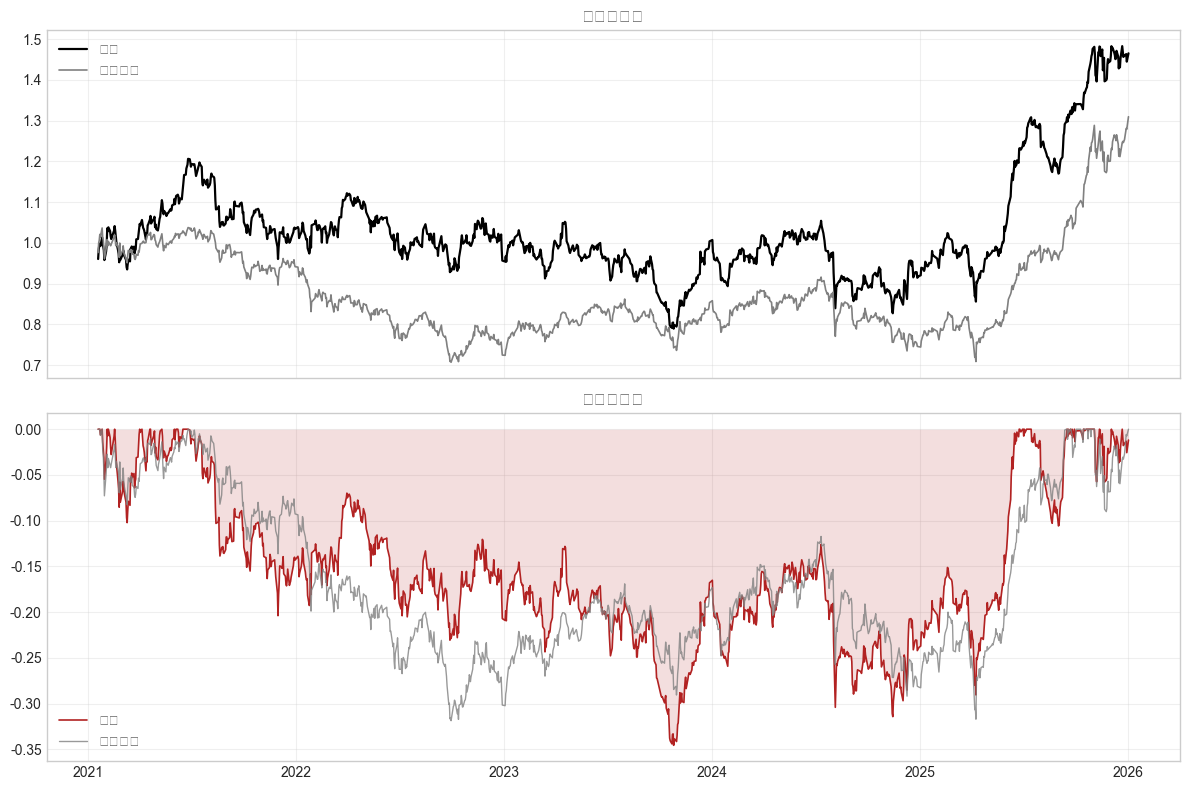

In [12]:
if not df_bt.empty:
    import matplotlib as mpl
    import matplotlib.font_manager as fm

    # 한글 폰트 설정
    preferred_fonts = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR", "Noto Sans KR"]
    available_fonts = {f.name for f in fm.fontManager.ttflist}
    for font in preferred_fonts:
        if font in available_fonts:
            mpl.rcParams["font.family"] = font
            break
    mpl.rcParams["axes.unicode_minus"] = False

    plt.style.use("seaborn-v0_8-whitegrid")

    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    axes[0].plot(df_bt.index, df_bt["cum"], color="black", lw=1.6, label="전략")
    if "bm_cum" in df_bt.columns:
        axes[0].plot(df_bt.index, df_bt["bm_cum"], color="gray", lw=1.2, label="벤치마크")
        axes[0].legend()
    axes[0].set_title("누적수익률")
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(df_bt.index, df_bt["drawdown"], color="firebrick", lw=1.2, label="전략")
    axes[1].fill_between(df_bt.index, df_bt["drawdown"], 0, color="firebrick", alpha=0.15, linewidth=0)
    if "bm_drawdown" in df_bt.columns:
        axes[1].plot(df_bt.index, df_bt["bm_drawdown"], color="gray", lw=1.0, alpha=0.8, label="벤치마크")
        axes[1].legend()
    axes[1].set_title("드로우다운")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()

In [ ]:
# Export results to a single Excel workbook (multi-sheet)
from pathlib import Path

EXPORT_PATH = Path("backtest") / "bl_daily_backtest_outputs.xlsx"
EXPORT_PATH.parent.mkdir(parents=True, exist_ok=True)


def _safe_df(x):
    return x if isinstance(x, pd.DataFrame) else pd.DataFrame()


def _safe_series(x):
    return x if isinstance(x, pd.Series) else pd.Series(dtype=float)


# 1) Config sheet
config_keys = [
    "EMBEDDING_PATH", "RETURN_PATH", "ADJ_CLOSE_PATH", "MCAP_PATH", "KOSPI_PATH", "RISK_FREE_PATH",
    "DATA_START_DATE",
    "RAW_TARGET_RETURN_COL", "TARGET_RETURN_COL", "BACKTEST_RETURN_COL",
    "WINDOW", "RIDGE_ALPHA", "MIN_TRAIN_SAMPLES", "MIN_REPORT_COUNT",
    "WINSOR_LOWER_Q", "WINSOR_UPPER_Q", "RISK_AVERSION", "RISK_FREE_TRADING_DAYS",
    "OMEGA_MIN_OBS", "OMEGA_FALLBACK_MSE", "OMEGA_WARMUP_DAYS",
    "MIN_COVERAGE", "TAU", "LONG_ONLY", "WEIGHT_CLIP",
    "TRANSACTION_COST_BPS", "SELL_TAX_BPS", "ANNUALIZATION",
]
config_rows = []
for k in config_keys:
    if k in globals():
        config_rows.append({"key": k, "value": globals()[k]})
config_df = pd.DataFrame(config_rows)

# 2) Ridge daily report counts (rolling-window based)
# n_train_reports_window: number of report rows used in ridge training block
# for each prediction date, based on the past WINDOW dates.
ridge_daily_report_count = pd.DataFrame()
if "df_model" in globals() and isinstance(df_model, pd.DataFrame) and len(df_model) > 0:
    df_tmp = df_model.dropna(subset=[TARGET_RETURN_COL]).copy()
    df_tmp["date"] = pd.to_datetime(df_tmp["date"])
    unique_dates = pd.DatetimeIndex(sorted(df_tmp["date"].unique()))

    rows = []
    if len(unique_dates) > WINDOW:
        for i in range(WINDOW, len(unique_dates)):
            pred_date = unique_dates[i]
            train_dates = unique_dates[i - WINDOW:i]

            train_block = df_tmp.loc[df_tmp["date"].isin(train_dates)].dropna(
                subset=embedding_cols + [TARGET_RETURN_COL]
            )
            test_block = df_tmp.loc[df_tmp["date"] == pred_date].dropna(subset=embedding_cols)

            rows.append({
                "date": pred_date,
                "n_train_reports_window": int(len(train_block)),
                "n_test_reports_date": int(len(test_block)),
                "used_for_fit": bool((len(train_block) >= MIN_TRAIN_SAMPLES) and (len(test_block) > 0)),
            })

    ridge_daily_report_count = pd.DataFrame(rows)
    if not ridge_daily_report_count.empty:
        ridge_daily_report_count = ridge_daily_report_count.set_index("date").sort_index()

if "df_pred" in globals() and isinstance(df_pred, pd.DataFrame) and len(df_pred) > 0:
    pred_cnt = df_pred.groupby("date").size().rename("n_predicted")
    if ridge_daily_report_count.empty:
        ridge_daily_report_count = pred_cnt.to_frame()
    else:
        ridge_daily_report_count = ridge_daily_report_count.join(pred_cnt, how="left")

if not ridge_daily_report_count.empty:
    if "n_predicted" in ridge_daily_report_count.columns:
        ridge_daily_report_count["n_predicted"] = ridge_daily_report_count["n_predicted"].fillna(0).astype(int)

# 3) Daily risk aversion
risk_aversion_daily = pd.DataFrame()
if "risk_df" in globals() and isinstance(risk_df, pd.DataFrame):
    risk_aversion_daily = risk_df.copy()

if not risk_aversion_daily.empty:
    risk_aversion_daily["risk_aversion"] = float(RISK_AVERSION)

if not risk_aversion_daily.empty:
    risk_aversion_daily = risk_aversion_daily.sort_index()

# 4) Backtest daily
backtest_daily = pd.DataFrame()
if "df_bt" in globals() and isinstance(df_bt, pd.DataFrame) and len(df_bt) > 0:
    backtest_daily = df_bt.copy().reset_index().rename(columns={"index": "date"})

# 5) Weights (long + requested wide)
weights_daily_long = pd.DataFrame()
weights_daily = pd.DataFrame()  # requested: index=date, columns=ticker_code, values=weight
if "weights_history" in globals() and isinstance(weights_history, pd.DataFrame) and len(weights_history) > 0:
    weights_daily_long = weights_history.copy()
    weights_daily = (
        weights_history
        .pivot_table(index="date", columns="ticker_code", values="weight", aggfunc="mean")
        .sort_index()
        .fillna(0.0)
    )

# 6) Performance summary (if available)
performance_summary = pd.DataFrame()
if "summary" in globals():
    if isinstance(summary, pd.Series):
        performance_summary = summary.to_frame(name="value")
    elif isinstance(summary, pd.DataFrame):
        performance_summary = summary.copy()

with pd.ExcelWriter(EXPORT_PATH, engine="openpyxl") as writer:
    config_df.to_excel(writer, sheet_name="config", index=False)

    if not ridge_daily_report_count.empty:
        ridge_daily_report_count.to_excel(writer, sheet_name="ridge_daily_report_count")

    if "df_pred" in globals() and isinstance(df_pred, pd.DataFrame) and len(df_pred) > 0:
        df_pred.to_excel(writer, sheet_name="ridge_predictions", index=False)

    if not risk_aversion_daily.empty:
        risk_aversion_daily.to_excel(writer, sheet_name="risk_aversion_daily")

    if not backtest_daily.empty:
        backtest_daily.to_excel(writer, sheet_name="backtest_daily", index=False)

    if not weights_daily_long.empty:
        weights_daily_long.to_excel(writer, sheet_name="weights_daily_long", index=False)

    if not weights_daily.empty:
        weights_daily.to_excel(writer, sheet_name="weights_daily")

    if not performance_summary.empty:
        performance_summary.to_excel(writer, sheet_name="performance_summary")

print(f"saved: {EXPORT_PATH}")
